## Demo: Isotropic Reconstruction Without Isotropic Training Data.
This notebook demonstrates training a vEMDiffuse-a model for a 3D isotropic reconstruction task without isotropic training data. Note that training a neural network for actual use should be done with **more training time and more training data** as used here.

The demo data in this tutorial is downloaded from [MICrONS multi-area volume](https://www.microns-explorer.org/). The pixel size is 8 nm x 8 nm x 40 nm. The training objective is to achieve 8 nm x 8 nm x 8 nm resolution. 

## Set the Runtime Type on Google Colab

Set the Runtime type: Go to Runtime -> Change the Runtime type

Runtime type: Python 3 (Python 3 is programming language in which this program is written)

Accelator: GPU (Graphics processing unit (GPU)

## Download and Install EMDiffuse

In [ ]:
!git clone https://github.com/Luchixiang/EMDiffuse
%cd EMDiffuse/.
!pip install -r requirements.txt

Note: Before starting, ensure that you're working within the 'EMDiffuse' directory. The directory can be checked with the `!pwd` command and adjusted with the `%cd` command. 

In [1]:
# %cd ../..

/home/cxlu/EMDiffuse


In [2]:
import sys
import os
import urllib
import zipfile
import glob
from tifffile import imread, imwrite
import matplotlib.pyplot as plt

## Download the Demo Data
The demo dataset consists of 24 continuous **YZ** layers cropped from MICrONS multi-area volume. Please note that the model needs more data to perform well for actual use. 

In [5]:
if not os.path.isdir('./dataset'):
    os.mkdir('./dataset')
zipPath="dataset/vEMDiffusea_data_demo.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://zenodo.org/records/10685890/files/vEMDiffusea_data_demo.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("dataset")

Text(0.5, 1.0, 'YZ Layer 24')

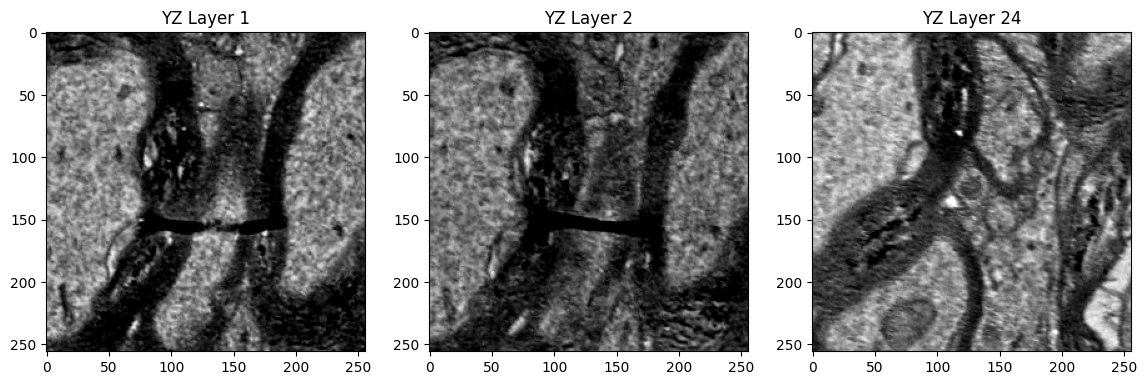

In [5]:
dataset_path = './dataset/vEMDiffusea_data_demo'
example_image_layer0 = imread(os.path.join(dataset_path, '0.tif'))[:256, :256]
example_image_layer1 = imread(os.path.join(dataset_path, '1.tif'))[:256, :256]
example_image_layer23 = imread(os.path.join(dataset_path, '23.tif'))[:256, :256]
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(example_image_layer0, cmap='gray')
plt.title('YZ Layer 1')
plt.subplot(1,3,2)
plt.imshow(example_image_layer1, cmap='gray')
plt.title('YZ Layer 2')
plt.subplot(1,3,3)
plt.imshow(example_image_layer23, cmap='gray')
plt.title('YZ Layer 24')

The image quality is low due to the anistropic resolution, but the trained model can be applied to XY views.

In [3]:
import core.praser as Praser
import os
import warnings
import torch
import torch.multiprocessing as mp
from core.logger import VisualWriter, InfoLogger
import core.praser as Praser
import core.util as Util
from data import define_dataloader
from models import create_EMDiffuse
from emdiffuse_conifg import EMDiffuseConfig
from run import main_worker

## Configuring the EMDiffuse Model and Training
Before we construct the actual EMDiffuse model, we have to define the model and training configurations via an `EMDiffuseConfig` object, which includes：
- path: The location of the training volume (YZ view).
- lr: The learning rate.
- config: Some basic parameters of the model and the dataset, including the network architecture, loss function, and noise scheduler of diffusion. Please see the JSON files for more details.
- batch_size: Training batch size on every gpu. 
- phase: The mode of operation, either train or test.
- subsample: The subsampling factor of the Z axis. In this example, to reconstruct an 8 nm x 8 nm x 8 nm volume from an 8 nm x 8 nm x 40 nm volume, the subsampling factor should be 5.


In [4]:
config = EMDiffuseConfig(config='config/vEMDiffuse-a.json', phase='train', 
                         path='./dataset/vEMDiffusea_data_demo/', batch_size=4, subsample=5, lr=5e-5)
opt = Praser.parse(config) # Parse the config
opt['world_size'] = 1 
Util.set_seed(opt['seed'])
model = create_EMDiffuse(opt)
print(f'length of training data loader: {len(model.phase_loader)}')

results and model will be saved in experiments/train_vEMDiffuse-a_240221_131922
the number of layers:  24
length of training data loader: 1248


## Training
Training the model will likely take some time. Both the model's state and its training metrics are automatically saved within a newly created directory, `./experiments/train_vEMDiffuse-a_time`, as logged above. Here, `time` is a placeholder for the actual timestamp when the training session begins, ensuring each session is uniquely identifiable.


Furthermore, you can look at the predictions for some validation images, which can help recognize problems early on. 

In [ ]:
model.train()

train/mse_loss: 0.22741706167161466	
train/mse_loss: 0.02431437000632286	
